# **EECS 16ML Assignment: Traditional/Contextual Word Embedding**

In this assignment, you are going to implement and apply the word embedding techniques you learn from notes and slides. Here, we introduce a real world machine learning task - sentiment analysis of movie reviews with binary classification. We have cleaned and pre-processed the data for you so that the dataset you have is a set of lists of words, where each list represents a single movie review.  

In each part, you are going to first implement a specific embedding technique from scratch, then practice utilizing existing packages that implement the same embedding technique for you. Finally, you will apply the embeddings on the movie reviews data and use a classification algorithm (here we will use linear support vector machine) to classify your embedded reviews. Make observation of the classification accuracies you achieve with each embedding technique and/or hyperparamters you use.

*Before you start, make sure you review the lecture slide and notes about word embedding.*

If you have any ImportError, run the following command.

In [1]:
# Install the packages/modules that you may not have
# !pip install <PACKAGE_NAME>
!pip install nltk
!pip install bs4
!pip install tqdm
!pip install keras
!pip install tensorflow
!pip install transformers

In [2]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from bs4 import BeautifulSoup
import re
import nltk
from nltk.stem.porter import PorterStemmer
# if error appears, uncomment the next line
# nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from collections import Counter
from collections import defaultdict
# Bert packages
import transformers
from tokenizers import BertWordPieceTokenizer
from keras.layers import Dense,Input
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.optimizers import Adam

# ----------------

In [3]:
warnings.filterwarnings('ignore')

### **Part 0: Data cleaning and Pre-process**

In this assignment, we will use IMDB dataset of 50,000 labeled movie reviews from [here](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) to perform classification task and compare performance using different word embedding methods. If you haven't done so yet, download [Data.zip](https://drive.google.com/file/d/14mFmHL-dHXICgi2jIRpnbOqVPsMz2QSa/view?usp=sharing) and unzip it inside `Assignment/` folder.

In [4]:
# Reading the dataset and visualize the first ten data points
path_data = 'Data/IMDB Dataset.csv'
imdb_data = pd.read_csv(path_data)
imdb_data.sentiment.replace("positive" , 1 , inplace = True)
imdb_data.sentiment.replace("negative" , 0 , inplace = True)
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [5]:
X_raw = imdb_data['review']
y = imdb_data['sentiment']

As you may have observed, the raw data of movie reviews contain a lot of symbols and HTML contents, which we want to remove since our embedding methods only take in words. Moreover, words like "a" and "to" are less meaningful in terms of differentiating positive and negative reviews. We also want to lower-case all the words so that capitalization doesn't result in different embedding for the same word/document. The following function will be used to clean the raw dataset.

In [6]:
# This function clean the input text by removing HTML contents, punctuation, stopwords, then lower-case each word
stopWords = set(stopwords.words('english'))
def preprocess_text(review):
    # remove HTML contents.
    soup = BeautifulSoup(review, "html.parser")
    review = soup.get_text()

    # remove everything except lower/upper case letters using Regular Expressions.
    review = re.sub('\[[^]]*\]', ' ', review)
    review = re.sub('[^a-zA-Z]', ' ', review)

    # bring everything into lowercase.
    review = review.lower()

    review = review.split()
    review = [word for word in review if not word in stopWords]

    return review


In [7]:
# Clean the raw data by applying the above function
tqdm.pandas()
X = X_raw.progress_apply(preprocess_text)

### **Part 1: Word-Count Vectors**

Now we are ready the apply different embedding techniques on the clean dataset. As explained in the lecture and notes, Bag of Words, which uses counts of word occurrences to transform texts into vectors of numbers, is an introductory and traditional count-based skill in text representation. Thus we will first implement and apply BoW. Since you have more experience in BoW in related unit and assignments, here we only ask you to implement from scratch how to embed a single document. 

**(a)** Define `vectorize` below to implement the Bag of Words approach, then apply `vectorizeDF` on the first 5,000 reviews. For this part, we only use 5000 reviews to test if your implemented function works since applying it on the whole dataset is time-consuming.

*hint: use `.value_counts()`*

In [8]:
# For now, use only first 5000 reviews
reviews_5000 = X[:5000]
y_5000 = y[:5000]

In [9]:
# This function turns a list of words into a vector by counting the occurences of every word in the list
# Input: bagOfWords - a list containing all the words in a review
# Output: vectorOfWords - a Pandas series containing occurences of every word in the input list
def vectorize(bagOfWords):
    #TODO 
    return pd.Series(bagOfWords).value_counts()

# This function applies vectorize() and vectorize all lists of words included in a Pandas dataframe
# Input: reviews - a Pandas dataframe containing all the reviews in *list of words* form
# Output: X_vectorized - a Pandas dataframe containing vectorized form of all reviews
def vectorizeDF(reviews):
    X_vectorized = reviews.progress_apply(vectorize)
    return X_vectorized

In [10]:
X_vectorized = vectorizeDF(reviews_5000).fillna(0)

Check if applying implemented `vectorize` to out lists of words produce correct length of vocabulary:

In [11]:
len(set(reviews_5000.explode())) == len(X_vectorized.columns)

True

Now we want to see how sparse is the vector we obtain.

In [12]:
# By running the cell, you can observe that most entries in the vector is 0, making it "sparse"
vec = X_vectorized.iloc[0].values
sum(vec == 0.0)/len(vec)

0.9965000518510837

Then, we use this vectorized data to train one of the most common models - SVM classifier and report accuracy on the movie review classification. Your result should be around 84%


 Accuracy:  0.854


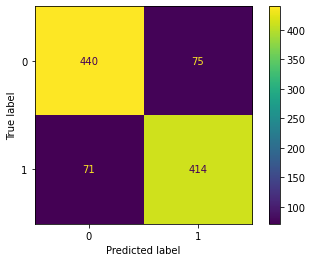

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_5000, test_size = 0.2)
clf = LinearSVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test)
print('\n Accuracy: ', accuracy_score(y_test, y_pred))

Counting single word occurrences can cost us some useful information in sentences, especially those words that have collective meanings when put together. For example, "machine learning" has a special meaning that words "machine" and "learning" cannot capture. In this case, we want to also count occurrences of each of the two words (bigrams) or multiple words (ngrams) that co-occur in texts.

**(b)** Define `bigram()` and `sixgram()` below

In [14]:
# This function turns a list of words into a list of 2-grams
# Input: bagOfWords - a list containing all the words in a review
# Output: bagOf2grams - a list of 2-grams: [(word1, word2), (word2, word3) ... ]
def bigram(bagOfWords):
    #TODO
    return [(bagOfWords[i], bagOfWords[i+1]) for i in range(len(bagOfWords)-1)]

In [15]:
reviews_5000.apply(bigram)

0       [(one, reviewers), (reviewers, mentioned), (me...
1       [(wonderful, little), (little, production), (p...
2       [(thought, wonderful), (wonderful, way), (way,...
3       [(basically, family), (family, little), (littl...
4       [(petter, mattei), (mattei, love), (love, time...
                              ...                        
4995    [(interesting, slasher), (slasher, film), (fil...
4996    [(watched, series), (series, first), (first, c...
4997    [(jet, li), (li, brings), (brings, charismatic...
4998    [(rented, movie), (movie, hearing), (hearing, ...
4999    [(big, disappointment), (disappointment, think...
Name: review, Length: 5000, dtype: object

`nltk` is a popular package that engineers use in the real world for text data pre-processing [(check documentation here)](http://www.nltk.org/api/nltk.html?highlight=ngram). It also provides a method `ngrams()` that can produce n-grams for us. Try utilize this method and define `sixgram()`.

In [16]:
from nltk import ngrams

In [17]:
# This function turns a list of words into a list of 6-grams
# Input: bagOfWords - a list containing all the words in a review
# Output: bagOf6grams - a list of 6-grams: [(word1, word2, word3, word4, word5, word6) ... ]
def sixgram(bagOfWords):
    #TODO
    return list(ngrams(bagOfWords, 6))

In [18]:
reviews_5000.apply(sixgram)

0       [(one, reviewers, mentioned, watching, oz, epi...
1       [(wonderful, little, production, filming, tech...
2       [(thought, wonderful, way, spend, time, hot), ...
3       [(basically, family, little, boy, jake, thinks...
4       [(petter, mattei, love, time, money, visually)...
                              ...                        
4995    [(interesting, slasher, film, multiple, suspec...
4996    [(watched, series, first, came, years, old), (...
4997    [(jet, li, brings, charismatic, presence, movi...
4998    [(rented, movie, hearing, chris, gore, saying)...
4999    [(big, disappointment, think, worst, mastroian...
Name: review, Length: 5000, dtype: object

In the real world, implementing Bag of Words from scratch can be computation-heavy, especially on large dataset with longer texts. Fortunately, `scikit-learn` has implemented it in an efficient way for us with `CountVectorizer` [(check documentation here)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

**(c)** Now using `CountVectorizer`, redefine `vectorizeDF()` and apply it on the whole dataset. Play with different parameters like `ngram_range` and `max_features`. **Report the parameters you try and the corresponding accuracy (at least two different combinations). Try and see if adding n-grams and number of features improve model performance.** Note that `CountVectorizer` has a method `get_features_name()` that shows all the word tokens after vectorized if you want to take a look.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Modify our review data into string sentence form
reviews = X.apply(lambda x: ' '.join(x))

In [20]:
# This function vectorize all texts included in a Pandas dataframe
# Input: reviews - a list containing all the reviews in *string sentence* form
# Output: X_vectorized - a numpy array containing vectorized form of all reviews
def vectorizeDF(reviews):
    # TODO
    # Hint: Remember to add max_features parameter if the dimension of the feature vector is too large
    vectorizer = CountVectorizer(ngram_range = (1, 3),max_features=500)
    X_vectorized = vectorizer.fit_transform(reviews)
    return X_vectorized.toarray()

In [21]:
X_vectorized = vectorizeDF(reviews)

Note that if the training time is quite long for the following cell, it might because the dimension of the feature vector is too large. Try to add `max_features` parameter in `CountVectorizer`.


 Accuracy:  0.8392


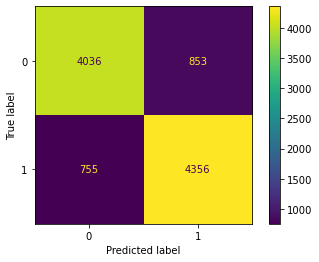

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size = 0.2)
clf = LinearSVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test)
print('\n Accuracy: ', accuracy_score(y_test, y_pred))

#### Start answering part 1(c)
Answers may vary among students. Students should give at least two trials.

Example:

    Parameters: ngram_range = (1, 2), max_features=1000, Accuracy: 85.69%
    Parameters: ngram_range = (1, 3), max_features=1000, Accuracy: 86.06%
    Parameters: ngram_range = (1, 3), max_features=500, Accuracy: 84.33%

#### End answering part 1(c)

### **Part 2: TF-IDF**

Next we will implement and apply Tf-idf, also a count-based approach but one that produce dense vectors. Tf-idf stands for term frequency-inverse document frequency. It is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. 


**(a)** Fill in the TODO parts of the following cell implement TF-IDF. We first compute term frequency (TF) and inverse document frequency (IDF) then multiply them. Calculate the TF-IDF scores of all words in all the reviews.

In [23]:
# This function computes the term frequency (TF), i.e. the number of times a word appears in a review divded 
# by the total number of words in the review.
# Input: bagOfWords - a list containing all the words in a review
# Output: tfDict - a dictionary containing the TF scores of all the words in a review
def computeTF(bagOfWords):
    # Frequency of each word in a review
    wordDict = dict(Counter(bagOfWords))
    tfDict = {}
    N = len(bagOfWords)
    # TODO: compute term frequency
    for word, count in wordDict.items():
        tfDict[word] = count / float(N)

    return tfDict

# This function computes the inverse document frequency (IDF), i.e. the number of reviews divided by the number 
# of reviews that contain the word w. 
# Input: reviews - a list containing all the reviews
# Output: idfDict - a dictionary containing the IDF score of all the words in all the reviews
def computeIDF(reviews):
    N = len(reviews)
    # create a dictionary with all the words as keys and 0 as value
    reviews = [dict(Counter(review)) for review in reviews]
    idfDict = dict.fromkeys(set().union(*(review.keys() for review in reviews)),0)
    # TODO: compute inverse document frequency
    # Hint: Don't forget to apply logarithm transformation 
    for document in reviews:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = np.log(N / float(val))
    
    return idfDict

# This function computes the TF-IDF score of all the words in a review
# Input: bagOfWords - a list containing all the words in a review
#        idfDict - a dictionary containing the IDF score of all the words in all the reviews
# Output: tfidf - a dictionary containing the TF-IDF scores of all the words in a review
def computeTFIDF(bagOfWords, idfDict):
    tfidf = {}  
    tfDict = computeTF(bagOfWords)
    # TODO: compute tf-idf
    for word, val in tfDict.items():
        tfidf[word] = val * idfs[word]
  
    return tfidf

In [24]:
# Again, in consideration of running rime, use only first 5000 reviews
idfs = computeIDF(reviews_5000)
total_vocab = list(idfs.keys())
tfidf = reviews_5000.progress_apply(computeTFIDF, idfDict=idfs)

After calculating the TF-IDF scores of all words in all the reviews, we need to map each review to a vector of scores. Notice that the dimension of each vector is the length of total unique words. Run the following cell. This might take 10 mins to run. 

In [25]:
def vectorized(tfidf_doc):
    vec = np.zeros(len(total_vocab))
    for word, val in tfidf_doc.items():
        ind = total_vocab.index(word)
        vec[ind] = val
    return vec

X_vectorized = list(tfidf.progress_apply(vectorized))

You have successfully transformed each review to a vector of real numbers. Congrats! 

Next, we need to apply the vectorized reviews to our sentimental classification problem. We choose the same model as last part.


 Accuracy:  0.858


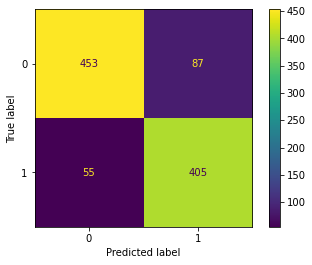

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_5000, test_size = 0.2)

clf = LinearSVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test)
print('\n Accuracy: ', accuracy_score(y_test, y_pred))

As you can see, vectorizing the first 5000 reviews using tf-idf methods take quite a long time. In real world, the size of dataset is much larger. Similiar to the last part, `scikit-learn` has implemented it in an efficient way for us with `TfidfVectorizer` [(check documentation here)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

**(b)** Apply `TfidfVectorizer` on the whole dataset and report the accuracy.

In [27]:
reviews = X.apply(lambda x: ' '.join(x))

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TODO 
tv=TfidfVectorizer()
tv_vectorized=tv.fit_transform(reviews)


 Accuracy:  0.89


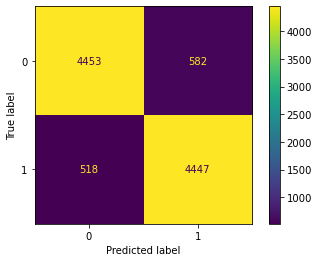

In [29]:
X_train, X_test, y_train, y_test = train_test_split(tv_vectorized, y, test_size = 0.2,
                                                    random_state = 0)

clf = LinearSVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test)
print('\n Accuracy: ', accuracy_score(y_test, y_pred))

**(c)** Comment on the result of TF-IDF with SVM classifier and compare the result with last part. Is the performace better or worse? Explain the reason to the best of your knowledge.

#### Starting answering part 2(c)
The accuracy of TF-IDF with SVM on the entire dataset is 89%.

The performance is better than Bag of words because Bag of Words just creates a set of vectors containing the count of word occurrences in the documents (reviews), while the TF-IDF model contains information on the more important words and the less important ones as well.

#### End answering part 2(c)

### Part 3: Co-Occurrence Matrix and GloVe

Words co-occurrence matrix is another frequency-based approach, but one that captures some semantic relationship. It describes how words occur together that in turn captures the relationships between words. Words co-occurrence matrix is computed simply by counting how two or more words occur together in a given corpus. 

**(a)** Fill in the following TODO part to finish implementation of `co_occ()` and compute the co-occurrence matrix.

In [30]:
# Compute the co-occurrence matrix of the corpus X
# Input: X - the tokenized sentences 
#        vocab - the dictionary which maps a word to its index in the words list
#        window_size - the size of the context window
def co_occ(X, vocab, window_size):
    n = len(vocab)
    matrix = np.zeros((n,n))
    # TODO
    for sentence in X:
        for i,word in enumerate(sentence):
            for j in range(max(i-window_size,0),min(i+window_size,len(sentence))):
                matrix[vocab[word]][vocab[sentence[j]]]+=1
    # end TODO
    return matrix


Run the following cell to build the co-occurrence matrix for 500 data

In [31]:
# create a dictionary for mapping word to its index in the words list
X_500 = X[:500]
data = {} 
vocab = {}
for tokens in X_500: 
    for word in tokens: 
        if word not in data: 
            data[word] = 1
        else: 
            data[word] += 1

words = sorted(list(data.keys()))
for i in range(len(data)): 
    vocab[words[i]] = i


# create co-occurrence matrix with window size = 5
co_matrix = co_occ(X_500, vocab, 5)

Note that Co-Occurrance matrix is not a word embedding that is generally used. Use PCA to decompose the matrix and reduce to K dimension. In addition, to maintain the semantic meaning of the word representation, K is preferred to be in the order of hundreds.

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=300)
pca.fit(co_matrix)
co_pca = pca.transform(co_matrix)

After the transformation by PCA, the matrix becomes |V| * K, with each row representing a word embedding. Now you are ready to apply the matrix into the task of movie sentiment analysis. 

**(b)** Implement `vectorize_co(X, model)` and run the following cells and report resulting accuracy. Here, we will simply average word vectors for sentence representation. (Due to the long fitting time and memory requirement for PCA, we limit the datasets of size 500, the accuracy can improve when the dataset is larger)

In [33]:
# vectorization of tokenized sentences with transformed co-occurrence matrix
# Input: X - the tokenized sentences
#        model - co-occurrence matrix
def vectorize_co(X, model):
    X_vectorized = []
    # TODO: vectorize each piece of text in X using co-occurrence matrix built
    for i in range(len(X)):
        X_words = []
        for word in X[i]:
            if(word in vocab):
                X_words.append(model[vocab[word]])
        X_vectorized.append(np.mean(np.array(X_words), axis = 0).reshape(-1))
    # end TODO
    return np.array(X_vectorized)

In [34]:
X_vectorized = vectorize_co(X, co_pca)


 Accuracy:  0.6897


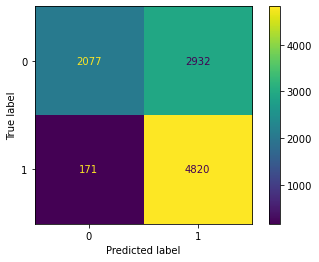

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size = 0.2)
clf = LinearSVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test)
print('\n Accuracy: ', accuracy_score(y_test, y_pred))

As you may have observed, building co-occurrence matrix and performing PCA ourselves can be time consuming especially when our training set has a large size. As a result, engineers in the industry utilize [GloVe](https://nlp.stanford.edu/projects/glove/). The website provides several different sets of pre-trained word vectors either with different dimensions or using different type of corpus. In other words, someone has built the co-occurrence matrices and performed PCA based on either wiki comments or tweets for us, thus saving us some work.

**(c)** Implement `vectorize_glove(X, dic)`. Load both 50-dim and 300-dim pretrained GloVe word vectors, then vectorize review data, perform classification, and report accuracies on both set of GloVe vectors. Again, we will use the average of word vectors for sentence representation.

In [36]:
# run this cell to load the 50-dimension GloVe word vectors 
embeddings_dict = {}
with open("Data/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        embeddings_dict[values[0]] = np.asarray(values[1:], "float32")

In [37]:
# vector for the word "king"
embeddings_dict['king']

array([ 0.50451 ,  0.68607 , -0.59517 , -0.022801,  0.60046 , -0.13498 ,
       -0.08813 ,  0.47377 , -0.61798 , -0.31012 , -0.076666,  1.493   ,
       -0.034189, -0.98173 ,  0.68229 ,  0.81722 , -0.51874 , -0.31503 ,
       -0.55809 ,  0.66421 ,  0.1961  , -0.13495 , -0.11476 , -0.30344 ,
        0.41177 , -2.223   , -1.0756  , -1.0783  , -0.34354 ,  0.33505 ,
        1.9927  , -0.04234 , -0.64319 ,  0.71125 ,  0.49159 ,  0.16754 ,
        0.34344 , -0.25663 , -0.8523  ,  0.1661  ,  0.40102 ,  1.1685  ,
       -1.0137  , -0.21585 , -0.15155 ,  0.78321 , -0.91241 , -1.6106  ,
       -0.64426 , -0.51042 ], dtype=float32)

In [38]:
# vectorization of tokenized sentences with pretrained GloVe vectors
# Input: X - the tokenized sentences
#        dic - dictionary of loaded GloVe vectors
def vectorize_glove(X, dic):
    X_vectorized = []
    # TODO
    for i in range(len(X)):
        X_words = []
        for word in X[i]:
            if(word in dic.keys()):
                X_words.append(dic[word])
        X_vectorized.append(np.mean(np.array(X_words), axis = 0).reshape(-1))
    # end TODO
    return np.array(X_vectorized)

In [39]:
X_vectorized = vectorize_glove(X, embeddings_dict)


 Accuracy:  0.7601


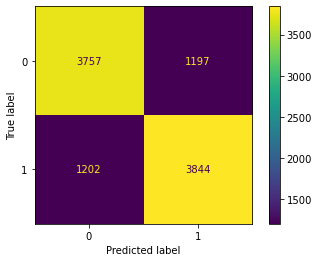

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size = 0.2)
clf = LinearSVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test)
print('\n Accuracy: ', accuracy_score(y_test, y_pred))

### Part 4: Word2Vec

### Why from count based model to predictive model?###
A common drawback among count/frequency-based approaches is their inability to capture word orders and semantics. Although Co-occurrence matrix preserves some semantic relationships, it requires huge memory to both compute and store the matrix. As a result, predictive models, driven by measures of loss in semantic and contextual information, are developed to make use of context and provide vector representations of words.

Word2Vec is a popular technique of natural language processing to create word embeddings using neural networks, which can be further used for various text related tasks, e.g. sentiment anlaysis. In this problem, we will walk you through the implementation of Skip-Gram model, and the use of Gensim, a popular pacakge for Word2Vec. 
<br>   
In week 2 of 16ML, you have learned the mechanism of gradient descent as well as the implementation of stochastic gradient descent. In this problem, we will let you implement parts of the train function, including generating input and target data from raw tokenized sentences, and compute losses.

**(a)**
The training objective (for one training sample) is to maximize the conditional probability of observing the actual context word $w_{Oj}$ given the input context word $w_I$.
\begin{equation*}
\ P(W_{O,1}, W_{O,2}, ... , W_{O,C}| W_I) = \prod_{c=1}^C\frac{e^{u_{j^*_c}}}{\sum_{j'=1}^V e^{u_{j'}}} 
\end{equation*}
Where $u$ is the output layer before softmax, and $u_{j^*_c}$ is the node of $c^{th}$ context word in the output layer.
<br> Derive the loss function $E$ by taking the negative log of the above expression, and further have that $$\frac{\partial E}{\partial u_j} = t_j - y_j$$

Solution:
\begin{equation}
\begin{split}
E &= -\log p(W_{O,1}, ..., W_{O,C} | W_I) \\
  &= -\log \prod_{c=1}^C\frac{e^{u_{j^*_c}}}{\sum_{j'=1}^{V} e^{u_{j'}}} \\
  &= -\sum_{c=1}^C u_{j^*_c} + C * \log \sum_{j'=1}^{V} e^{u_{j'}}
 \end{split}
\end{equation}

$$\frac{\partial E}{\partial u_j} = t_j - y_j$$

**(b)** The softmax function is a function that turns a vector of V real values into a vector of the same length that sums to 1, and each value is between 0 and 1, so that they can be interpreted as probabilities. Implement softmax function in the next cell. 
\begin{equation*}
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^V e^{z_j}}
\end{equation*}



In [41]:
def softmax(x):
    ## TODO: Compute softmax values for each sets of scores in x.
    return np.exp(x) / np.sum(np.exp(x), axis=0)

**(c)**
The following cell is the implementation of Word2Vec (Skip-Gram model) using stochastic gradient descent. Fill in the missing part labeled as TODD

In [42]:
class word2vec(object): 
    def __init__(self, eta = 0.005, window_size = 2, hidden_num = 10): 
      # self.N - the number of neurons in the single hidden layer
      # self.words - the list of words
      # self.eta - the learning rate
      # self.vocab - the dictionary which maps the word to its index of self.words
      # self.V - the length of the words list
      # self.W1 - the first weight matrix of dimension |V| * N
      # self.W2 - the second weight matrix of dimension N * |V|
      # self.h - the hidden layer
      # self.u - the output layer

        self.N = hidden_num
        self.window_size = window_size
        self.eta = eta
        self.words = [] 
        self.vocab = {}
        self.losses = []
        self.V = None
        self.W1 = None
        self.W2 = None
        self.h = None
        self.u = None
        

    def initialize(self, X):
        # build the vocabulary from the tokenized sentences and update self.V, self.words
        data = {} 
        for tokens in X: 
            for word in tokens: 
                if word not in data: 
                    data[word] = 1
                else: 
                    data[word] += 1
                    
        self.V = len(data) 
        self.words = sorted(list(data.keys())) 
        
        for i in range(len(data)): 
            self.vocab[self.words[i]] = i 
   
        self.W1 = np.random.uniform(-0.8, 0.8, (self.V, self.N)) 
        self.W2 = np.random.uniform(-0.8, 0.8, (self.N, self.V)) 


    # Implement the forward function, update self.h and self.u, and return the result of softmax classification
    # X - the one hot vectors of center words
    def forward(self,X): 
        # TODO: update self.h and self.u, and return the result of softmax classification
        self.h = np.dot(self.W1.T,X).reshape(self.N,1) 
        self.u = np.dot(self.W2.T,self.h) 

        return softmax(self.u)   
  
    # Implement the backward function, update self.W1 and self.W2
    # input: X - the one hot vector of center word
    #        y - the output of softmax classification
    #        target - the representation of center word's context words in a single vector
    def backward(self,X,y,target): 
        # TODO: update self.W1 and self.W2
        du = y - np.array(target).reshape(-1,1) 
        dw2 = np.dot(self.h,du.T) 
        dh = np.dot(self.W2,du)
        dw1 = np.dot(np.array(X).reshape(-1,1), dh.T) 

        self.W2 = self.W2 - self.eta * dw2
        self.W1 = self.W1 - self.eta * dw1 
           
    def train(self,epochs, X):
        numTokens = len(sum(X, []))
        iterable = range(numTokens)
        itbar = tqdm(iterable)
        for e in epochs: 
            itbar.refresh()
            itbar.reset()
            self.loss = 0
            vocab = self.vocab

            for sentence in X: 
                for i in range(len(sentence)): 
                    itbar.update()
                    
                    ## TODO
                    # You need to process tokens of sentences (self.X) into valid training points
                    # 1. the input x (center_word) is an one hot encoding vector of the length of the vocabulary  
                    # 2. the output y (context_word) is of the same length of x, which has 1's in the sliding window of
                    #    the center_word except the center_word itself. Be catious of the boundary
                    
                    center_word = [0 for x in range(self.V)] 
                    center_word[vocab[sentence[i]]] = 1
                    context = [0 for x in range(self.V)] 

                    for j in range(i-w2v.window_size,i+w2v.window_size): 
                        if i!=j and j>=0 and j<len(sentence): 
                            context[vocab[sentence[j]]] += 1
                    
                    y = self.forward(center_word) 
                    self.backward(center_word, y, context) 
                    
                    ## TODO
                    # compute the loss based on the formula you derived
                    C = 0
                    for m in range(self.V): 
                        if(context[m]): 
                            self.loss += -1*self.u[m][0] 
                            C += 1
                    self.loss += C*np.log(np.sum(np.exp(self.u))) 
            
            self.losses.append(self.loss)
            if((e+1) % 10 == 0):
                print("epoch ",e+1, " loss = ",self.loss) 
            self.eta *= 1/( (1+self.eta*(e+1)) ) 

            
    # return context words of the given center word or None if word isn't in the vocabulary
    # Input: word - the center word
    #        num - the number of context words to return
    def predict(self,word,num): 
        if word in self.words: 
            # TODD:
            X = [0 for i in range(self.V)] 
            X[self.vocab[word]] = 1
            prediction = self.forward(X) 
            output = {} 
            for i in range(self.V): 
                output[prediction[i][0]] = i 
               
            top_context_words = [] 
            for k in sorted(output,reverse=True): 
                top_context_words.append(self.words[output[k]]) 
                if(len(top_context_words)>=num): 
                    break
       
            return top_context_words 
        else: 
            return None


**(d)**
Because word2vec takes long time to train, you only use the following experiment to test your implementation. Run the next cell and train a word2vec embedding model using your implementation 

In [43]:
X_w2v = X[:50]
w2v = word2vec() 
w2v.initialize(X_w2v)

# train 100 epochs, you should see your loss is contantly decreasing
epochs = tqdm(range(100))
w2v.train(epochs,X_w2v) 

epoch  10  loss =  132348.77207523602
epoch  20  loss =  129580.3621610221
epoch  30  loss =  127718.94100694232
epoch  40  loss =  126567.33963768998
epoch  50  loss =  125807.53353694122
epoch  60  loss =  125284.42712386356
epoch  70  loss =  124909.29914514821
epoch  80  loss =  124629.95275226759
epoch  90  loss =  124415.26617445114
epoch  100  loss =  124245.923436483



You should see your loss is constantly decreasing, visualize the loss over 100 epochs by running the following cell

Text(0.5, 0, 'epoch')

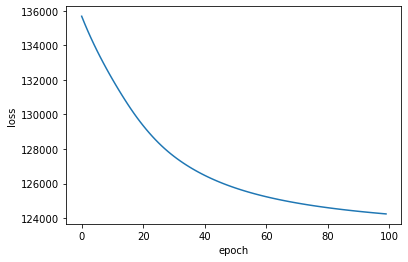

In [44]:
fig, ax = plt.subplots()
ax.plot(w2v.losses)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')

Although the loss hasn't decreased to a descent number, the model should have learned meaningful representations for words. Check the performance of this model by letting it predict context words for the word you provide

In [84]:
# check your context words
print(w2v.predict("good",5)) 

['time', 'one', 'actors', 'like', 'bad']


**(e)**
Besides Skip Gram model that you just implemented in the previous part, Continuous Bag of Words (CBOW) is another model for Word2Vec.`Gensim` is a useful library to train your word2vec model faster [(check documentation here)](https://radimrehurek.com/gensim/models/word2vec.html). Compare the performance of CBOW and Skip Gram by using Gensim.

In [72]:
from gensim.models import Word2Vec

model_cbow = Word2Vec(X, sg = 0)
model_skip_gram = Word2Vec(X, sg = 1)

Compare CBOW and Skip Gram by looking at the 5 most closest words to your input word. The words should be semantically close to the input word

In [82]:
# For CBOW
closest_cbow = model_cbow.predict_output_word(['good'],5)
closest_cbow = [a[0] for a in closest_cbow]
print("CBOW:", closest_cbow)

# For Skip Gram
closest_skip_gram = model_skip_gram.predict_output_word(['good'],5)
closest_skip_gram = [a[0] for a in closest_skip_gram]
print("Skip Gram:", closest_skip_gram)

CBOW: ['job', 'natured', 'pretty', 'hearted', 'performances']
Skip Gram: ['pretty', 'acting', 'job', 'actors', 'enough']


**(f)**
After you finish training your word2vec model with gensim, vectorize your tokenized sentences. For each sentence as a data point, we simply average the embedding of each word in this sentence. Implement the vectorize_word2vec function.

In [47]:
# Use trained word2vec model to vectorize the sentences. 
# Input: X - the tokenized sentences
#        model - the trained word2vec model
# return X_vectorized of dimension N * dim_embedding
def vectorize_word2vec(X, model):
    X_vectorized = []
    # TODD:
    # Hint: model['word'] will give the embedding of the word "word"
    for i in range(len(X)):
        X_words = []
        for word in X[i]:
            if(word in model):
                X_words.append(model[word])
        X_vectorized.append(np.mean(np.array(X_words), axis = 0).reshape(-1))
    return np.array(X_vectorized)

X_cbow = vectorize_word2vec(X, model_cbow)
X_skip_gram = vectorize_word2vec(X, model_skip_gram)


After creating the word embedding for the movie reviews with CBOW and Skip Gram separately. Use linear SVM on the movie sentiment classification task to compare the effectiveness of CBOW and SKip Gram.


 Accuracy for word embedding by CBOW:  0.8658


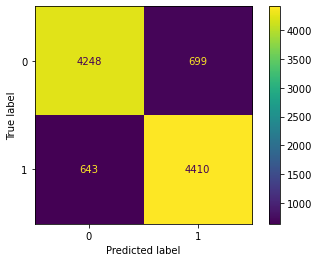

In [48]:
# For CBOW 
X_train, X_test, y_train, y_test = train_test_split(X_cbow, y, test_size = 0.2)

clf = LinearSVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

plot_confusion_matrix(clf, X_test, y_test)
print('\n Accuracy for sentiment analysis with CBOW: ', accuracy_score(y_test, y_pred))


 Accuracy for word embedding by Skip Gram:  0.8805


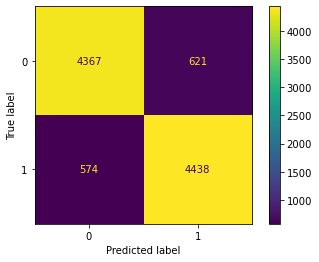

In [49]:
# For Skip Gram
X_train, X_test, y_train, y_test = train_test_split(X_skip_gram, y, test_size = 0.2)

clf = LinearSVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test)

print('\n Accuracy for sentiment analysis with Skip Gram: ', accuracy_score(y_test, y_pred))

### **Part 5: BERT**

In the last section, we will introduce a state-of-the-art word embedding model called BERT (Bidirectional Encoder Representations from Transformers). It was created and published in 2018 by Jacob Devlin and his colleagues from Google. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks. If you are interested in the details of the Bert model, you can refer to their paper: https://arxiv.org/pdf/1810.04805.pdf

In this assignment, we will use pre-trained BertWordPieceTokenizer to preprocess the reviews and the pre_trained TFDistilBertModel to classify the reviews.

In [50]:
# Load the pre-trained tokenizer
tokenizer = BertWordPieceTokenizer('Data/vocab.txt', lowercase=True)

In [51]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding()
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
        
    # Padding the last chunk
    res = np.zeros((len(all_ids), maxlen))
    for x in range(len(all_ids)):
        for y in range(len(all_ids[x])):
            res[x][y] = all_ids[x][y]
    return res

In [52]:
# Apply the pre_trained tokenizer on our dataset
X_raw_5000 = X_raw[:5000]
y_5000 = y[:5000]
X_tokenized = fast_encode(X_raw_5000.values, tokenizer, maxlen=400)
X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y_5000, test_size = 0.2)

In [53]:
def build_model(transformer, max_len=400):  
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(name='Movie_Reviews_Classification',inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [54]:
# Load the pre_trained tokenizer
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# Customize the pre_trained model to fullfill our task
model = build_model(bert_model, max_len=400)
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "Movie_Reviews_Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 400)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________________________


After intializing the model, we need to apply it on the movie reviews dataset. Since the training process takes hours to run with CPU, we have trained the result for you. You can skip the next cell and load the results in the following cell directly. If you want to experiment with the training process, feel free to uncomment the code in the next cell.

In [55]:
# The following line takes hours to run, so don't uncomment it unless you want to experiment the training process.
# model.fit(X_train,y_train,batch_size = 32 ,validation_data=(X_test,y_test),epochs = 3)

In [56]:
model.load_weights("Data/bert_model")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1])

32/32 [==============================] - 339s 11s/step - loss: 0.2784 - accuracy: 0.8920
Accuracy of the model on Testing Data is -  0.8920000195503235


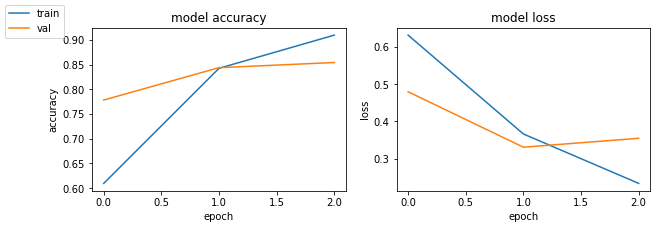

In [57]:
history = np.load('Data/my_history.npy',allow_pickle='TRUE').item()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axes[0].plot(history['accuracy'])
axes[0].plot(history['val_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')


axes[1].plot(history['loss'])
axes[1].plot(history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')

fig.legend(['train', 'val'], loc='upper left')


### Answer the following questions

(a) Comment on the result of Bert model and compare it with the previous models (Remember we only train the first 5000 reviews in Bert model).

(b) Comment on the graph of model accuracy and loss. What do you think will happen if we run the model with more ephochs?

#### Start answering part5
(a) The accuracy of Bert model is 89.7%. Though it only has 5000 reviews, the performance is almost the same or even better than all the other methods with entire dataset. 

(b) As the number of epoches increases, the accuracy increases and the validation loss first decreases and then increases. From the graph, we notice that the marginal increase of accuracy is decreasing. Therefore, if we have more ephoches, the accuracy might still increase, but the margin increase of accuracy might decrease. Also, since the validation loss increases from ephoch 1 to 2, running more ephoches might not help the performance much.
#### End answering part5